In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from math import radians, cos, sin, asin, sqrt
import numpy as np

In [3]:
input_csv_path = 'data/NY_HOURLY_RIDERSHIP_2022.csv'
output_csv_path = 'data/NY_SAMPLED_RIDERSHIP_2022.csv'
holidays_csv_path = 'data/Holidays Dataset US.csv'

# Sampling the dataset

In [27]:
chunk_size = 10000

In [21]:
sample_start_date = '2023-01-01'
sample_end_date = '2023-01-31'

In [29]:
# Create an iterator over chunks of the CSV file
chunk_iter = pd.read_csv(input_csv_path, chunksize=chunk_size, parse_dates=['transit_timestamp'], date_parser = lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'))

sampled_chunks = []

for chunk in chunk_iter:
    filtered_chunk = chunk[(chunk['transit_timestamp'] >= sample_start_date) & (chunk['transit_timestamp'] <= sample_end_date)]
    
    if not filtered_chunk.empty:
        sampled_chunks.append(filtered_chunk)

C:\Users\Israe\AppData\Local\Temp\ipykernel_66372\3694857730.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  chunk_iter = pd.read_csv(input_csv_path, chunksize=chunk_size, parse_dates=['transit_timestamp'], date_parser = lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'))


In [30]:
sampled_df = pd.concat(sampled_chunks)
sampled_df.to_csv(output_csv_path, index=False)

# Preprocessing

In [22]:
sampled_df = pd.read_csv(output_csv_path, parse_dates=['transit_timestamp'])

C:\Users\Israe\AppData\Local\Temp\ipykernel_33780\643414969.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  sampled_df = pd.read_csv(output_csv_path, parse_dates=['transit_timestamp'])


In [23]:
sampled_df = sampled_df.drop('payment_method', axis=1)
sampled_df = sampled_df.drop('fare_class_category', axis=1)
sampled_df = sampled_df.drop('Georeference', axis=1)
sampled_df = sampled_df.drop('transit_mode', axis=1)

KeyError: "['payment_method'] not found in axis"

In [ ]:
sampled_df['date'] = sampled_df['transit_timestamp'].dt.date
sampled_df['hour'] = sampled_df['transit_timestamp'].dt.hour
sampled_df['day_of_week'] = sampled_df['transit_timestamp'].dt.day_name()
sampled_df['weekday'] = sampled_df['transit_timestamp'].dt.weekday

In [ ]:
# Adding a is holiday column

holidays_dataset = pd.read_csv(holidays_csv_path)

holidays_dataset = holidays_dataset[holidays_dataset['Type'] == "['National holiday']"]

holidays_dataset['Date'] = pd.to_datetime(holidays_dataset['Date'], errors='coerce')
holiday_dates = set(holidays_dataset['Date'].dt.date)

sampled_df['is_holiday'] = sampled_df['date'].apply(lambda x: x in holiday_dates)

In [ ]:
sampled_df.to_csv(output_csv_path, index=False)

# Data analysis

In [4]:
sampled_df = pd.read_csv(output_csv_path, parse_dates=['transit_timestamp'])

C:\Users\Israe\AppData\Local\Temp\ipykernel_10316\643414969.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  sampled_df = pd.read_csv(output_csv_path, parse_dates=['transit_timestamp'])


In [5]:
render_graphs = True

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

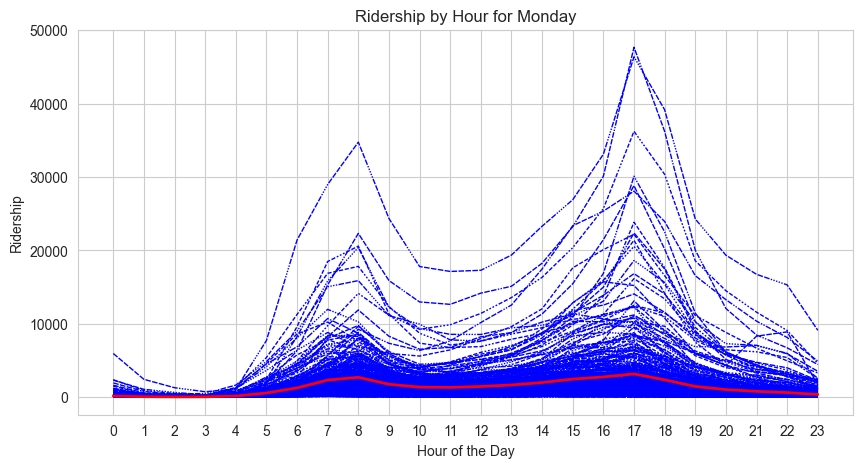

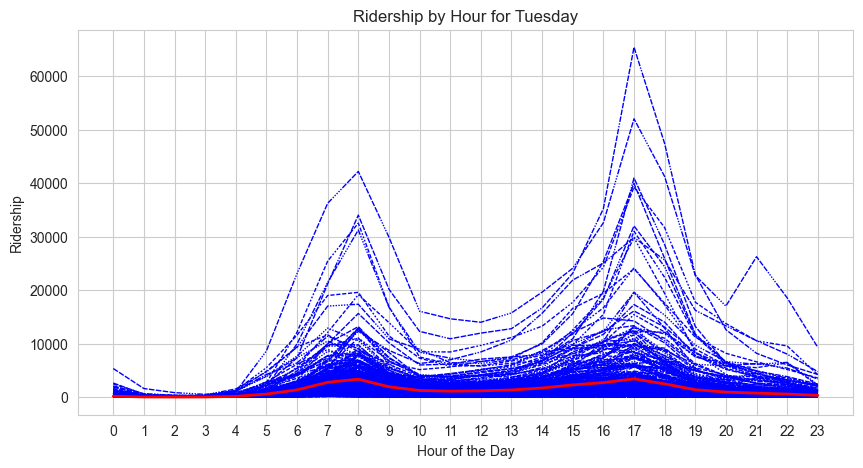

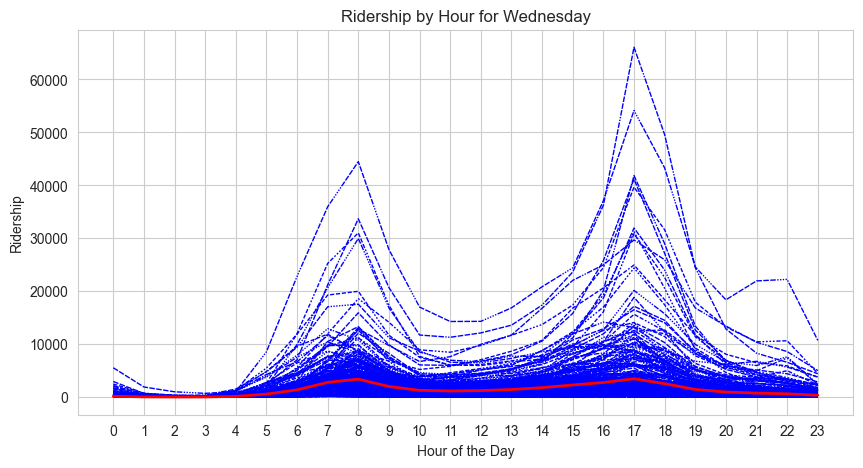

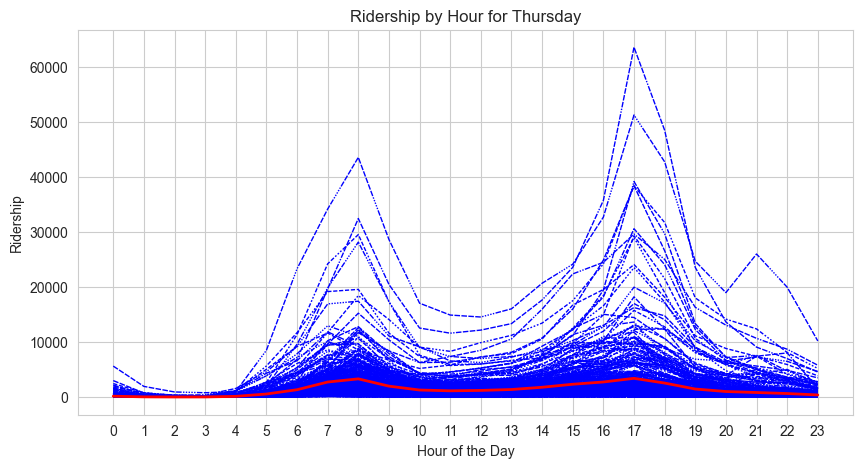

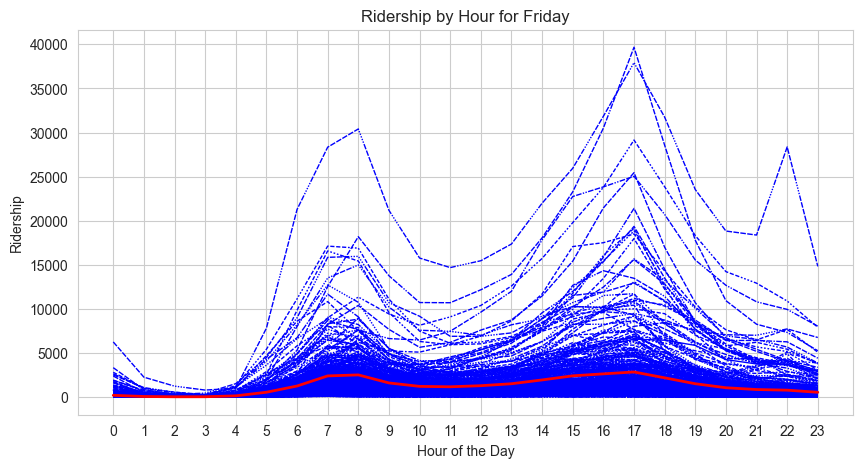

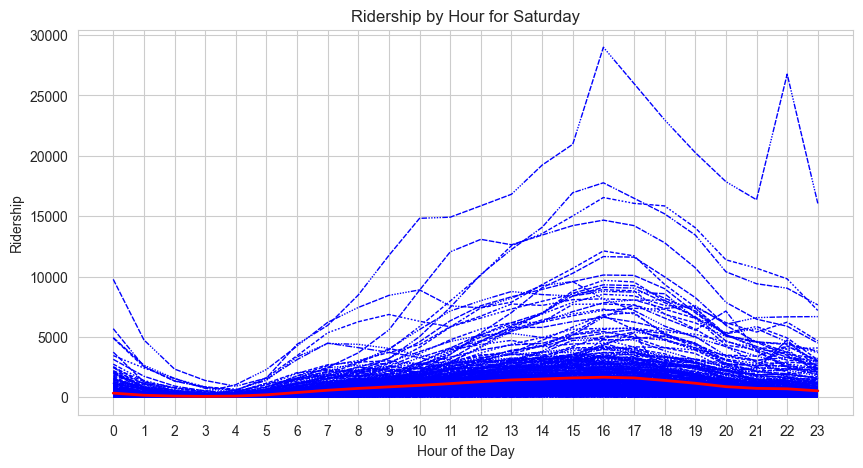

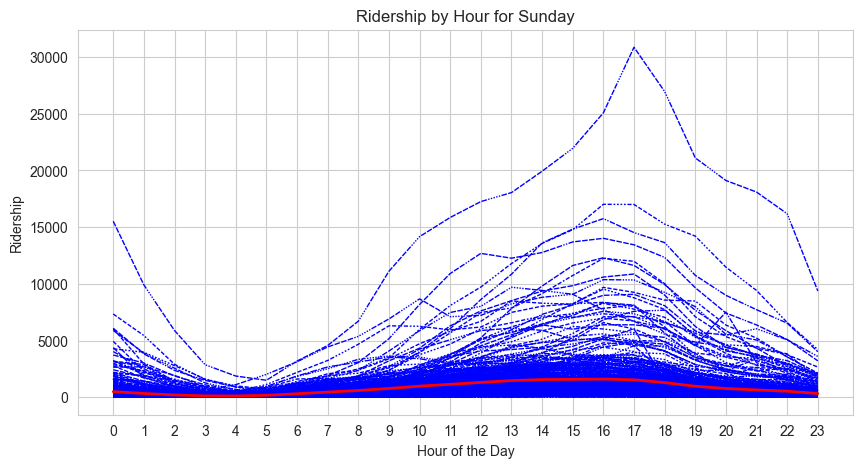

In [6]:
if render_graphs:
    for day in days_order:
        day_df = sampled_df[sampled_df['day_of_week'] == day]
    
        pivot_df = day_df.pivot_table(index='hour', columns='station_complex', values='ridership', aggfunc='sum')
    
        pivot_df['Average'] = pivot_df.mean(axis=1)
    
        plt.figure(figsize=(10, 5)) 
        sns.lineplot(data=pivot_df.drop(columns=['Average']), palette=['blue']*(len(pivot_df.columns)-1), legend=False, linewidth=1)
        sns.lineplot(data=pivot_df['Average'], color='red', linewidth=2) 
        plt.title(f'Ridership by Hour for {day}')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Ridership')
        plt.xticks(range(24))
        plt.show()

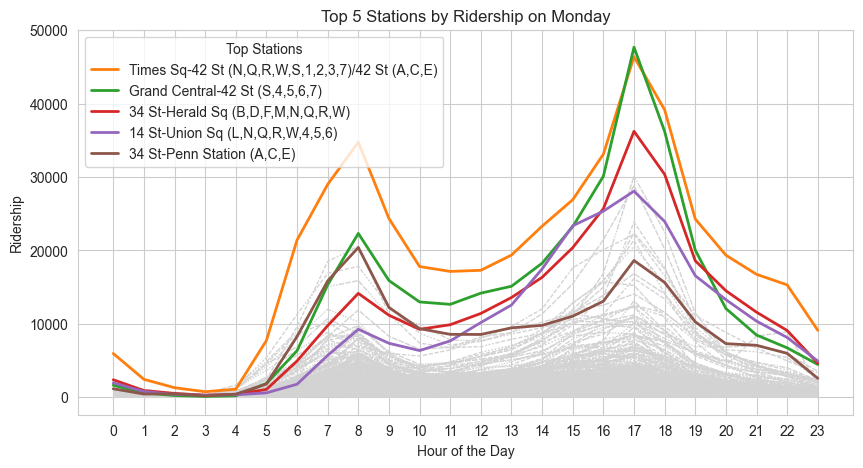

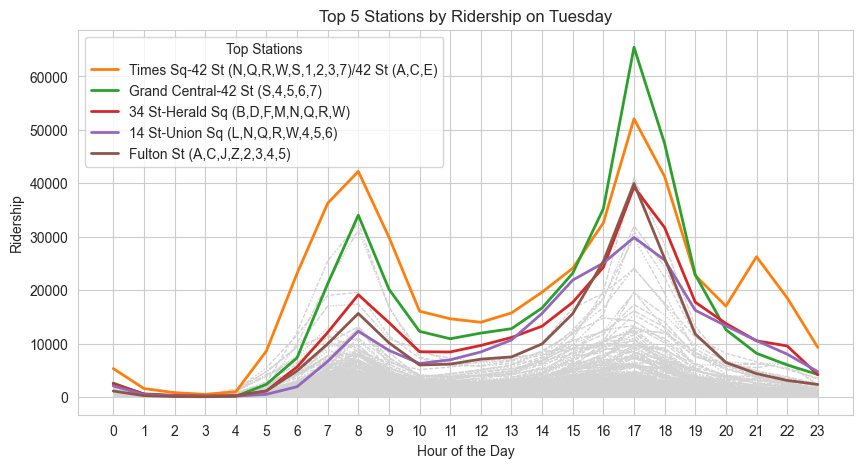

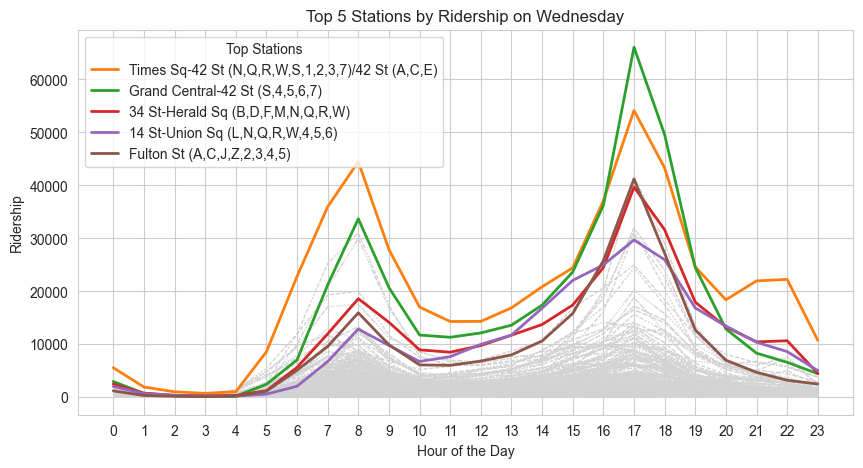

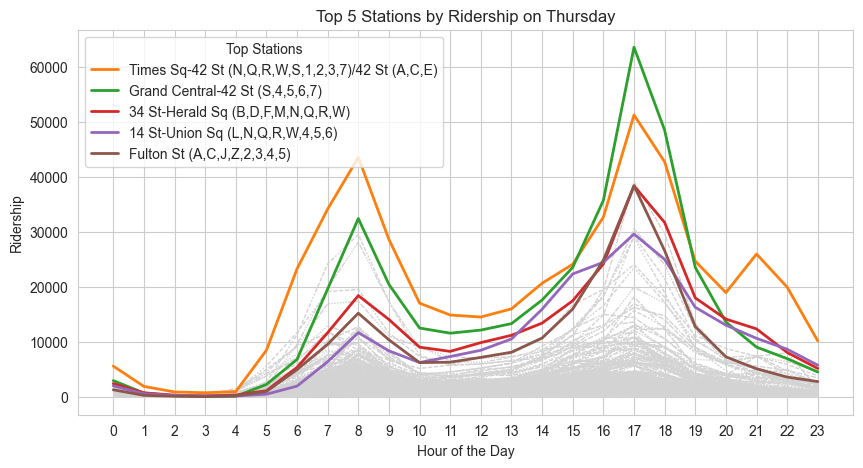

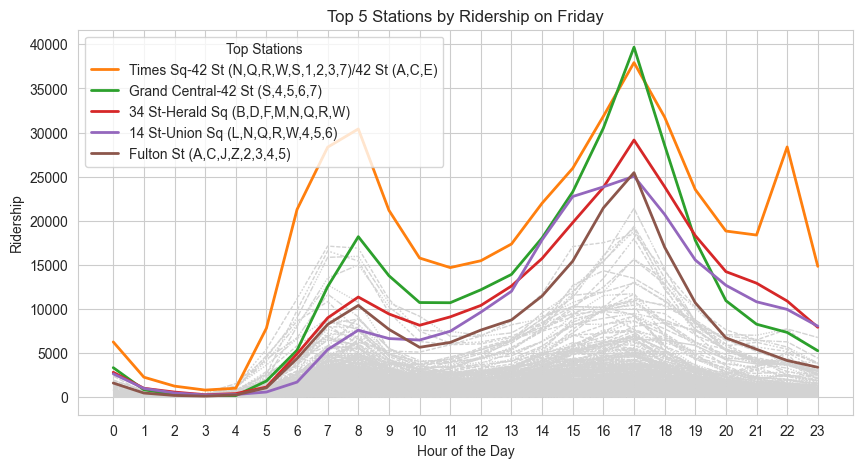

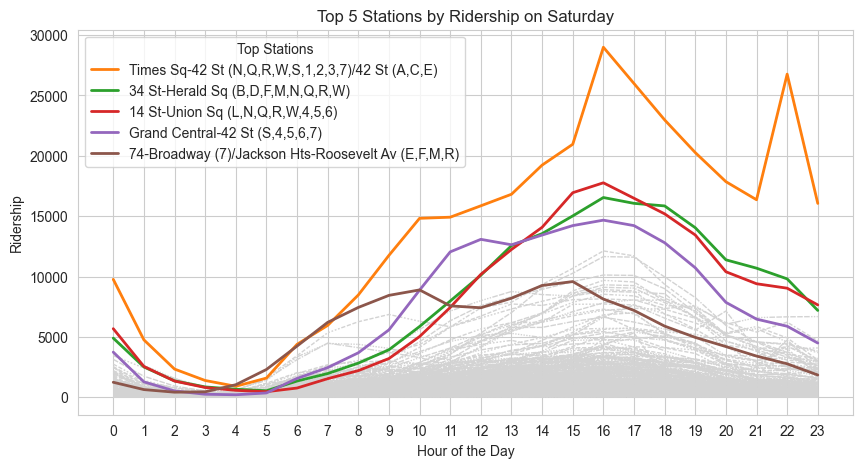

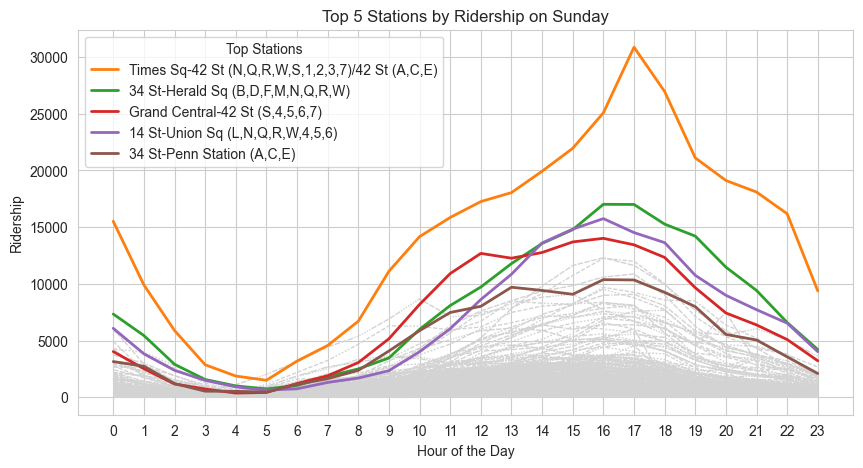

In [7]:
if render_graphs:
    for day in days_order:
        # Filter data for the specific day
        day_df = sampled_df[sampled_df['day_of_week'] == day]
    
        # Aggregate data by hour and station
        pivot_df = day_df.pivot_table(index='hour', columns='station_complex', values='ridership', aggfunc='sum')
    
        # Identify the top 5 stations for the day
        top_stations = pivot_df.sum().nlargest(5).index
    
        # Plot
        plt.figure(figsize=(10, 5))  # Adjust size if needed
        # Plot all stations with subdued color
        sns.lineplot(data=pivot_df, palette=['lightgrey']*len(pivot_df.columns), legend=False, linewidth=1)
        
        # Highlight the top 5 stations and label them
        for station in top_stations:
            sns.lineplot(data=pivot_df[station], label=station, linewidth=2)
        
        plt.title(f'Top 5 Stations by Ridership on {day}')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Ridership')
        plt.xticks(range(24))  # 0 to 23 hours
        plt.legend(title='Top Stations')
        plt.show()

## Clustering

In [10]:
def map_hour_to_period(hour):
    if 1 <= hour <= 6:
        return 1
    elif 7 <= hour <= 12:
        return 2
    elif 13 <= hour <= 18:
        return 3
    elif 19 <= hour <= 24 or hour == 0:
        return 4

In [11]:
sampled_df['period'] = sampled_df['hour'].apply(map_hour_to_period)

grouped_df = sampled_df.groupby(['period', 'station_complex_id']).agg({
    'ridership': 'sum',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index() 

In [26]:
print(grouped_df.head())

   period          station_complex  ridership   latitude  longitude
0       1                 1 Av (L)      13995  40.730953 -73.981628
1       1               103 St (1)       7020  40.799446 -73.968376
2       1               103 St (6)      10027  40.790600 -73.947479
3       1             103 St (C,B)       3044  40.796093 -73.961456
4       1  103 St-Corona Plaza (7)      73102  40.749866 -73.862701


In [12]:
features = grouped_df[['ridership', 'period', 'station_complex_id']]

# Normalização
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

ValueError: could not convert string to float: 'TRAM1'

In [28]:
k = 6

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_scaled)
grouped_df['cluster'] = clusters

In [ ]:
eps = 0.5  
min_samples = 5 

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(features_scaled)

grouped_df['cluster'] = clusters


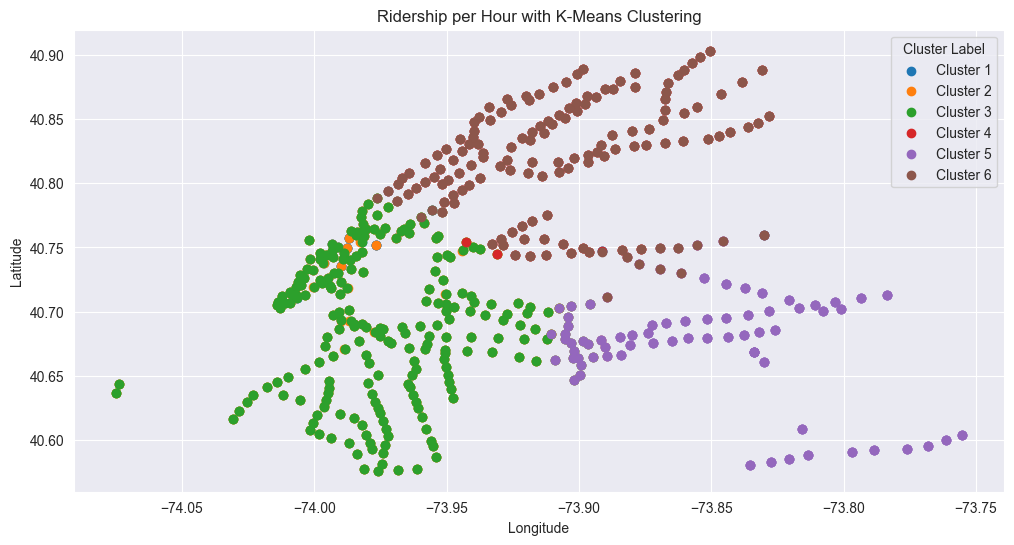

In [37]:
plt.figure(figsize=(12, 6))

u_labels = np.unique(clusters)

for i in u_labels:
    cluster_data = grouped_df[grouped_df['cluster'] == 5-i]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f"Cluster {i + 1}")

plt.legend(title="Cluster Label", loc='upper right')
plt.title('Ridership per Hour with K-Means Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


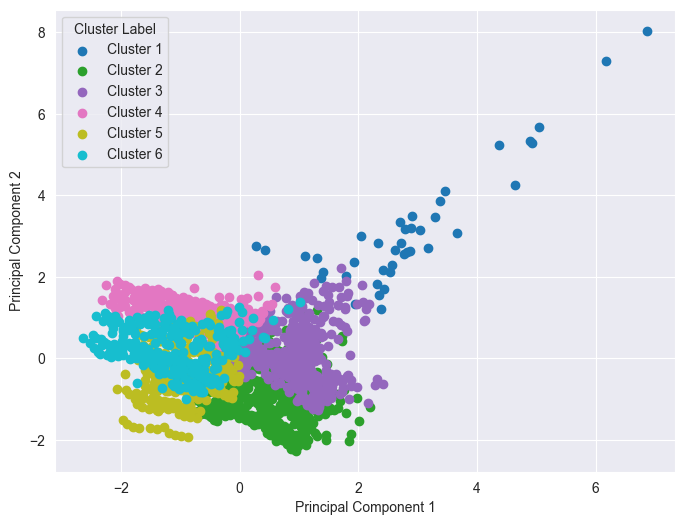

In [32]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))

unique_clusters = np.unique(clusters)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for color, cluster in zip(colors, unique_clusters):
    cluster_data = features_pca[clusters == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], color=color, label=f'Cluster {cluster + 1}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Cluster Label")
plt.show()

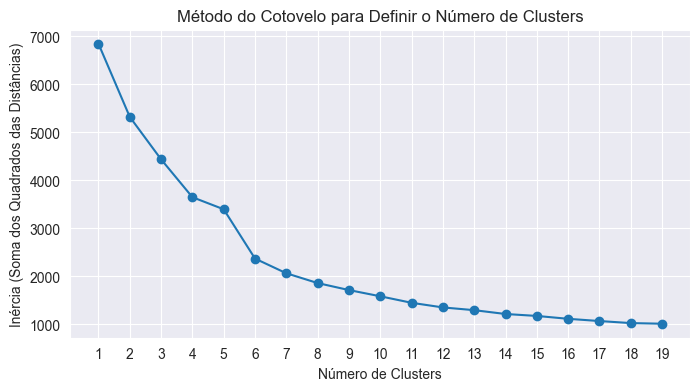

In [31]:
# Lista para guardar as inércias
inertias = []

# Lista para o número de clusters
num_clusters = range(1, 20)  # Geralmente, começamos com 1 e terminamos em algum número que parece razoável para o conjunto de dados

# Calculando a inércia para cada número de clusters
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

# Plotando o método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(num_clusters, inertias, '-o')
plt.title('Método do Cotovelo para Definir o Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Soma dos Quadrados das Distâncias)')
plt.xticks(num_clusters)
plt.show()